# Method 3 - Rest Ideas After 15

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calculate Intra-Portfolio Cap Weight

valid_data['weight'] = valid_data['market_cap_val_cur'] / valid_data.groupby(
    ['datadate', 'institution_id'])['market_cap_val_cur'].transform('sum')

# Calculate Intra-Portfolio Cap Weight Tilt

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Rest Ideas

In [3]:
# Extract Rest Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] > 15].copy()

# Weight the best ideas

best_ideas['target'] = best_ideas['target'] / best_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / best_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

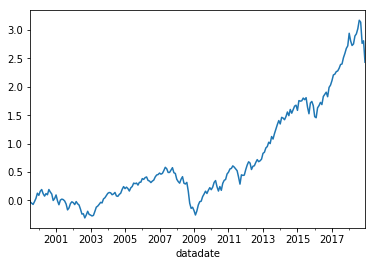

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.126894
2000-12-31   -0.083182
2001-12-31   -0.055974
2002-12-31   -0.226712
2003-12-31    0.439193
2004-12-31    0.145291
2005-12-31    0.062558
2006-12-31    0.101809
2007-12-31    0.013083
2008-12-31   -0.403307
2009-12-31    0.391986
2010-12-31    0.196212
2011-12-31   -0.013243
2012-12-31    0.194481
2013-12-31    0.393091
2014-12-31    0.112554
2015-12-31   -0.002942
2016-12-31    0.135272
2017-12-31    0.228252
2018-12-31   -0.077445
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     3497.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.81e-204
Time:                        13:21:40   Log-Likelihood:                 862.65
No. Observations:                 234   AIC:                            -1715.
Df Residuals:                     229   BIC:                            -1698.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.000      4.652      0.000       0.001       0.003
mktrf          1.0201      0.011     89.241      0.000       0.998       1.043
me             0.1580      0.013     11.879      0.000       0.132       0.184
ia             0.0185      0.020      0.915      0.361      -0.021       0.058
roe           -0.0642      0.017     -3.710      0.000      -0.098      -0.030
==============================================================================
Omnibus:                       14.746   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               37.222
Skew:                          -0.156   Prob(JB):                     8.27e-09
Kurtosis:                       4.929   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     1654.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.28e-167
Time:                        13:21:40   Log-Likelihood:                 862.65
No. Observations:                 234   AIC:                            -1715.
Df Residuals:                     229   BIC:                            -1698.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.000      4.056      0.000       0.001       0.003
mktrf          1.0201      0.014     74.529      0.000       0.993       1.047
me             0.1580      0.019      8.446      0.000       0.121       0.195
ia             0.0185      0.036      0.518      0.605      -0.052       0.088
roe           -0.0642      0.027     -2.381      0.017      -0.117      -0.011
==============================================================================
Omnibus:                       14.746   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               37.222
Skew:                          -0.156   Prob(JB):                     8.27e-09
Kurtosis:                       4.929   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     1635.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.56e-167
Time:                        13:21:40   Log-Likelihood:                 862.65
No. Observations:                 234   AIC:                            -1715.
Df Residuals:                     229   BIC:                            -1698.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.000      4.045      0.000       0.001       0.003
mktrf          1.0201      0.014     72.208      0.000       0.992       1.048
me             0.1580      0.017      9.267      0.000       0.125       0.191
ia             0.0185      0.037      0.495      0.621      -0.055       0.092
roe           -0.0642      0.031     -2.078      0.038      -0.125      -0.004
==============================================================================
Omnibus:                       14.746   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               37.222
Skew:                          -0.156   Prob(JB):                     8.27e-09
Kurtosis:                       4.929   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     2754.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.31e-201
Time:                        13:21:40   Log-Likelihood:                 861.35
No. Observations:                 234   AIC:                            -1711.
Df Residuals:                     228   BIC:                            -1690.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000      4.087      0.000       0.001       0.003
mktrf          1.0320      0.012     89.406      0.000       1.009       1.055
smb            0.1710      0.015     11.230      0.000       0.141       0.201
hml            0.0144      0.018      0.804      0.422      -0.021       0.050
rmw           -0.0606      0.020     -2.987      0.003      -0.101      -0.021
cma            0.0188      0.026      0.728      0.467      -0.032       0.070
==============================================================================
Omnibus:                       20.708   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               78.182
Skew:                          -0.084   Prob(JB):                     1.05e-17
Kurtosis:                       5.827   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     2776.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.23e-202
Time:                        13:21:40   Log-Likelihood:                 861.35
No. Observations:                 234   AIC:                            -1711.
Df Residuals:                     228   BIC:                            -1690.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000      3.804      0.000       0.001       0.003
mktrf          1.0320      0.011     95.725      0.000       1.011       1.053
smb            0.1710      0.021      8.009      0.000       0.129       0.213
hml            0.0144      0.038      0.376      0.707      -0.061       0.090
rmw           -0.0606      0.028     -2.149      0.032      -0.116      -0.005
cma            0.0188      0.037      0.513      0.608      -0.053       0.091
==============================================================================
Omnibus:                       20.708   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               78.182
Skew:                          -0.084   Prob(JB):                     1.05e-17
Kurtosis:                       5.827   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     3434.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.26e-212
Time:                        13:21:40   Log-Likelihood:                 861.35
No. Observations:                 234   AIC:                            -1711.
Df Residuals:                     228   BIC:                            -1690.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000      3.613      0.000       0.001       0.003
mktrf          1.0320      0.010     98.946      0.000       1.012       1.052
smb            0.1710      0.018      9.588      0.000       0.136       0.206
hml            0.0144      0.040      0.362      0.718      -0.064       0.093
rmw           -0.0606      0.032     -1.896      0.058      -0.123       0.002
cma            0.0188      0.036      0.520      0.603      -0.052       0.090
==============================================================================
Omnibus:                       20.708   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               78.182
Skew:                          -0.084   Prob(JB):                     1.05e-17
Kurtosis:                       5.827   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     3316.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.32e-201
Time:                        13:21:40   Log-Likelihood:                 856.53
No. Observations:                 234   AIC:                            -1703.
Df Residuals:                     229   BIC:                            -1686.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000      4.064      0.000       0.001       0.003
mktrf          1.0307      0.011     95.400      0.000       1.009       1.052
smb            0.1909      0.013     14.159      0.000       0.164       0.218
hml            0.0298      0.013      2.223      0.027       0.003       0.056
umd           -0.0329      0.009     -3.743      0.000      -0.050      -0.016
==============================================================================
Omnibus:                       17.188   Durbin-Watson:                   1.854
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.662
Skew:                          -0.109   Prob(JB):                     3.67e-12
Kurtosis:                       5.314   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     2492.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.89e-187
Time:                        13:21:40   Log-Likelihood:                 856.53
No. Observations:                 234   AIC:                            -1703.
Df Residuals:                     229   BIC:                            -1686.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      3.332      0.001       0.001       0.003
mktrf          1.0307      0.013     77.655      0.000       1.005       1.057
smb            0.1909      0.017     11.500      0.000       0.158       0.223
hml            0.0298      0.035      0.856      0.392      -0.038       0.098
umd           -0.0329      0.014     -2.393      0.017      -0.060      -0.006
==============================================================================
Omnibus:                       17.188   Durbin-Watson:                   1.854
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.662
Skew:                          -0.109   Prob(JB):                     3.67e-12
Kurtosis:                       5.314   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     2896.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.49e-195
Time:                        13:21:40   Log-Likelihood:                 856.53
No. Observations:                 234   AIC:                            -1703.
Df Residuals:                     229   BIC:                            -1686.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.001      3.148      0.002       0.001       0.003
mktrf          1.0307      0.013     80.495      0.000       1.006       1.056
smb            0.1909      0.016     11.673      0.000       0.159       0.223
hml            0.0298      0.039      0.763      0.445      -0.047       0.106
umd           -0.0329      0.013     -2.585      0.010      -0.058      -0.008
==============================================================================
Omnibus:                       17.188   Durbin-Watson:                   1.854
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.662
Skew:                          -0.109   Prob(JB):                     3.67e-12
Kurtosis:                       5.314   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     1770.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.95e-102
Time:                        13:21:40   Log-Likelihood:                 430.03
No. Observations:                 120   AIC:                            -850.1
Df Residuals:                     115   BIC:                            -836.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      3.676      0.000       0.001       0.004
mktrf          1.0107      0.018     57.115      0.000       0.976       1.046
me             0.1440      0.017      8.240      0.000       0.109       0.179
ia             0.0638      0.027      2.332      0.021       0.010       0.118
roe           -0.0920      0.024     -3.796      0.000      -0.140      -0.044
==============================================================================
Omnibus:                        7.138   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.028   Jarque-Bera (JB):               10.384
Skew:                          -0.248   Prob(JB):                      0.00556
Kurtosis:                       4.353   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     1152.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.33e-92
Time:                        13:21:40   Log-Likelihood:                 430.03
No. Observations:                 120   AIC:                            -850.1
Df Residuals:                     115   BIC:                            -836.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      3.128      0.002       0.001       0.004
mktrf          1.0107      0.022     46.581      0.000       0.968       1.053
me             0.1440      0.021      6.810      0.000       0.103       0.185
ia             0.0638      0.041      1.568      0.117      -0.016       0.144
roe           -0.0920      0.031     -2.959      0.003      -0.153      -0.031
==============================================================================
Omnibus:                        7.138   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.028   Jarque-Bera (JB):               10.384
Skew:                          -0.248   Prob(JB):                      0.00556
Kurtosis:                       4.353   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     1692.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.75e-101
Time:                        13:21:40   Log-Likelihood:                 430.03
No. Observations:                 120   AIC:                            -850.1
Df Residuals:                     115   BIC:                            -836.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.001      2.990      0.003       0.001       0.004
mktrf          1.0107      0.020     49.353      0.000       0.971       1.051
me             0.1440      0.021      6.987      0.000       0.104       0.184
ia             0.0638      0.037      1.704      0.088      -0.010       0.137
roe           -0.0920      0.035     -2.640      0.008      -0.160      -0.024
==============================================================================
Omnibus:                        7.138   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.028   Jarque-Bera (JB):               10.384
Skew:                          -0.248   Prob(JB):                      0.00556
Kurtosis:                       4.353   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     1239.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.41e-97
Time:                        13:21:40   Log-Likelihood:                 422.69
No. Observations:                 120   AIC:                            -833.4
Df Residuals:                     114   BIC:                            -816.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.795      0.000       0.001       0.004
mktrf          1.0585      0.020     53.130      0.000       1.019       1.098
smb            0.1759      0.023      7.794      0.000       0.131       0.221
hml            0.0006      0.028      0.022      0.982      -0.054       0.055
rmw           -0.0419      0.033     -1.286      0.201      -0.107       0.023
cma            0.0761      0.036      2.129      0.035       0.005       0.147
==============================================================================
Omnibus:                       13.750   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               31.405
Skew:                          -0.370   Prob(JB):                     1.52e-07
Kurtosis:                       5.394   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     1728.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.13e-105
Time:                        13:21:40   Log-Likelihood:                 422.69
No. Observations:                 120   AIC:                            -833.4
Df Residuals:                     114   BIC:                            -816.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.461      0.001       0.001       0.004
mktrf          1.0585      0.020     51.718      0.000       1.018       1.099
smb            0.1759      0.031      5.595      0.000       0.114       0.237
hml            0.0006      0.063      0.010      0.992      -0.123       0.124
rmw           -0.0419      0.048     -0.882      0.378      -0.135       0.051
cma            0.0761      0.042      1.812      0.070      -0.006       0.158
==============================================================================
Omnibus:                       13.750   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               31.405
Skew:                          -0.370   Prob(JB):                     1.52e-07
Kurtosis:                       5.394   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     3156.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.98e-120
Time:                        13:21:40   Log-Likelihood:                 422.69
No. Observations:                 120   AIC:                            -833.4
Df Residuals:                     114   BIC:                            -816.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.001      3.327      0.001       0.001       0.004
mktrf          1.0585      0.018     58.192      0.000       1.023       1.094
smb            0.1759      0.027      6.417      0.000       0.122       0.230
hml            0.0006      0.067      0.009      0.993      -0.131       0.132
rmw           -0.0419      0.052     -0.801      0.423      -0.145       0.061
cma            0.0761      0.041      1.878      0.060      -0.003       0.155
==============================================================================
Omnibus:                       13.750   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               31.405
Skew:                          -0.370   Prob(JB):                     1.52e-07
Kurtosis:                       5.394   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     1476.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.42e-98
Time:                        13:21:40   Log-Likelihood:                 419.33
No. Observations:                 120   AIC:                            -828.7
Df Residuals:                     115   BIC:                            -814.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      4.015      0.000       0.001       0.004
mktrf          1.0376      0.017     60.875      0.000       1.004       1.071
smb            0.1984      0.019     10.226      0.000       0.160       0.237
hml            0.0480      0.019      2.470      0.015       0.010       0.087
umd           -0.0352      0.012     -2.939      0.004      -0.059      -0.011
==============================================================================
Omnibus:                       11.672   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               21.645
Skew:                          -0.375   Prob(JB):                     1.99e-05
Kurtosis:                       4.941   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     1318.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.87e-95
Time:                        13:21:40   Log-Likelihood:                 419.33
No. Observations:                 120   AIC:                            -828.7
Df Residuals:                     115   BIC:                            -814.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      3.937      0.000       0.001       0.004
mktrf          1.0376      0.020     50.845      0.000       0.998       1.078
smb            0.1984      0.022      8.904      0.000       0.155       0.242
hml            0.0480      0.046      1.033      0.302      -0.043       0.139
umd           -0.0352      0.017     -2.121      0.034      -0.068      -0.003
==============================================================================
Omnibus:                       11.672   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               21.645
Skew:                          -0.375   Prob(JB):                     1.99e-05
Kurtosis:                       4.941   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     1669.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          8.11e-101
Time:                        13:21:40   Log-Likelihood:                 419.33
No. Observations:                 120   AIC:                            -828.7
Df Residuals:                     115   BIC:                            -814.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      3.936      0.000       0.001       0.004
mktrf          1.0376      0.017     59.412      0.000       1.003       1.072
smb            0.1984      0.024      8.360      0.000       0.152       0.245
hml            0.0480      0.052      0.932      0.351      -0.053       0.149
umd           -0.0352      0.016     -2.251      0.024      -0.066      -0.005
==============================================================================
Omnibus:                       11.672   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               21.645
Skew:                          -0.375   Prob(JB):                     1.99e-05
Kurtosis:                       4.941   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     1999.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.68e-101
Time:                        13:21:40   Log-Likelihood:                 448.93
No. Observations:                 114   AIC:                            -887.9
Df Residuals:                     109   BIC:                            -874.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.000      2.927      0.004       0.000       0.002
mktrf          1.0322      0.014     72.804      0.000       1.004       1.060
me             0.1821      0.022      8.321      0.000       0.139       0.226
ia            -0.1017      0.030     -3.349      0.001      -0.162      -0.042
roe           -0.0453      0.027     -1.698      0.092      -0.098       0.008
==============================================================================
Omnibus:                        6.880   Durbin-Watson:                   2.263
Prob(Omnibus):                  0.032   Jarque-Bera (JB):                6.685
Skew:                          -0.462   Prob(JB):                       0.0354
Kurtosis:                       3.745   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     3445.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.01e-113
Time:                        13:21:40   Log-Likelihood:                 448.93
No. Observations:                 114   AIC:                            -887.9
Df Residuals:                     109   BIC:                            -874.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.000      3.536      0.000       0.001       0.002
mktrf          1.0322      0.011     94.920      0.000       1.011       1.053
me             0.1821      0.018      9.984      0.000       0.146       0.218
ia            -0.1017      0.026     -3.879      0.000      -0.153      -0.050
roe           -0.0453      0.026     -1.751      0.080      -0.096       0.005
==============================================================================
Omnibus:                        6.880   Durbin-Watson:                   2.263
Prob(Omnibus):                  0.032   Jarque-Bera (JB):                6.685
Skew:                          -0.462   Prob(JB):                       0.0354
Kurtosis:                       3.745   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     5585.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.40e-125
Time:                        13:21:40   Log-Likelihood:                 448.93
No. Observations:                 114   AIC:                            -887.9
Df Residuals:                     109   BIC:                            -874.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.000      3.834      0.000       0.001       0.002
mktrf          1.0322      0.009    111.804      0.000       1.014       1.050
me             0.1821      0.016     11.313      0.000       0.151       0.214
ia            -0.1017      0.028     -3.663      0.000      -0.156      -0.047
roe           -0.0453      0.025     -1.796      0.072      -0.095       0.004
==============================================================================
Omnibus:                        6.880   Durbin-Watson:                   2.263
Prob(Omnibus):                  0.032   Jarque-Bera (JB):                6.685
Skew:                          -0.462   Prob(JB):                       0.0354
Kurtosis:                       3.745   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     3274.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.78e-116
Time:                        13:21:40   Log-Likelihood:                 489.91
No. Observations:                 114   AIC:                            -967.8
Df Residuals:                     108   BIC:                            -951.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      2.018      0.046     1.2e-05       0.001
mktrf          1.0294      0.009    108.569      0.000       1.011       1.048
smb            0.1391      0.015      9.035      0.000       0.109       0.170
hml            0.0198      0.020      1.010      0.315      -0.019       0.059
rmw           -0.1507      0.024     -6.270      0.000      -0.198      -0.103
cma           -0.1369      0.031     -4.485      0.000      -0.197      -0.076
==============================================================================
Omnibus:                        2.516   Durbin-Watson:                   2.359
Prob(Omnibus):                  0.284   Jarque-Bera (JB):                2.243
Skew:                          -0.099   Prob(JB):                        0.326
Kurtosis:                       3.658   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     7481.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.94e-135
Time:                        13:21:40   Log-Likelihood:                 489.91
No. Observations:                 114   AIC:                            -967.8
Df Residuals:                     108   BIC:                            -951.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      2.634      0.008       0.000       0.001
mktrf          1.0294      0.007    147.759      0.000       1.016       1.043
smb            0.1391      0.014     10.127      0.000       0.112       0.166
hml            0.0198      0.018      1.099      0.272      -0.016       0.055
rmw           -0.1507      0.016     -9.490      0.000      -0.182      -0.120
cma           -0.1369      0.034     -4.023      0.000      -0.204      -0.070
==============================================================================
Omnibus:                        2.516   Durbin-Watson:                   2.359
Prob(Omnibus):                  0.284   Jarque-Bera (JB):                2.243
Skew:                          -0.099   Prob(JB):                        0.326
Kurtosis:                       3.658   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     9747.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.25e-141
Time:                        13:21:40   Log-Likelihood:                 489.91
No. Observations:                 114   AIC:                            -967.8
Df Residuals:                     108   BIC:                            -951.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      2.834      0.005       0.000       0.001
mktrf          1.0294      0.006    168.146      0.000       1.017       1.041
smb            0.1391      0.011     12.252      0.000       0.117       0.161
hml            0.0198      0.016      1.214      0.225      -0.012       0.052
rmw           -0.1507      0.016     -9.466      0.000      -0.182      -0.120
cma           -0.1369      0.031     -4.388      0.000      -0.198      -0.076
==============================================================================
Omnibus:                        2.516   Durbin-Watson:                   2.359
Prob(Omnibus):                  0.284   Jarque-Bera (JB):                2.243
Skew:                          -0.099   Prob(JB):                        0.326
Kurtosis:                       3.658   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2582.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.83e-107
Time:                        13:21:40   Log-Likelihood:                 463.36
No. Observations:                 114   AIC:                            -916.7
Df Residuals:                     109   BIC:                            -903.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.674      0.502      -0.001       0.001
mktrf          1.0412      0.012     87.951      0.000       1.018       1.065
smb            0.1743      0.018      9.445      0.000       0.138       0.211
hml           -0.0219      0.019     -1.152      0.252      -0.060       0.016
umd           -0.0288      0.014     -2.006      0.047      -0.057      -0.000
==============================================================================
Omnibus:                        3.042   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.218   Jarque-Bera (JB):                2.505
Skew:                          -0.254   Prob(JB):                        0.286
Kurtosis:                       3.518   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     4171.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.25e-118
Time:                        13:21:40   Log-Likelihood:                 463.36
No. Observations:                 114   AIC:                            -916.7
Df Residuals:                     109   BIC:                            -903.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.851      0.395      -0.000       0.001
mktrf          1.0412      0.011     94.574      0.000       1.020       1.063
smb            0.1743      0.015     11.612      0.000       0.145       0.204
hml           -0.0219      0.016     -1.374      0.169      -0.053       0.009
umd           -0.0288      0.016     -1.771      0.077      -0.061       0.003
==============================================================================
Omnibus:                        3.042   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.218   Jarque-Bera (JB):                2.505
Skew:                          -0.254   Prob(JB):                        0.286
Kurtosis:                       3.518   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     5879.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.70e-126
Time:                        13:21:40   Log-Likelihood:                 463.36
No. Observations:                 114   AIC:                            -916.7
Df Residuals:                     109   BIC:                            -903.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.998      0.318      -0.000       0.001
mktrf          1.0412      0.011     98.204      0.000       1.020       1.062
smb            0.1743      0.011     15.189      0.000       0.152       0.197
hml           -0.0219      0.013     -1.630      0.103      -0.048       0.004
umd           -0.0288      0.016     -1.753      0.080      -0.061       0.003
==============================================================================
Omnibus:                        3.042   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.218   Jarque-Bera (JB):                2.505
Skew:                          -0.254   Prob(JB):                        0.286
Kurtosis:                       3.518   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""